## Learning python for image classification

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data



In [23]:
#imports
import cv2
import glob

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [81]:
#constants

IMG_SIZE = 64
TRAIN_DIR = './train'
TEST_DIR = './test'
CAT_LABEL = 0
DOG_LABEL = 1
LR = 1e-3

MODEL_NAME = 'dogs-vs-cats-tensorflow-3.model'

In [82]:
def loadImages(train=True):
    image_list = []
    label_list = []
    path = TEST_DIR
    if train :
        path = TRAIN_DIR
    for file in glob.glob(path + '/*'): #assuming gif
        #read a file in grayscale
        im = cv2.imread(file, 0)
        #resize the image
        im = cv2.resize(im, (IMG_SIZE,IMG_SIZE))

        #define the one-hot label
        label = CAT_LABEL if file.split('.')[1].endswith('cat') else DOG_LABEL

        #append to a image_list    
        image_list.append(im)
        label_list.append(label)


    return np.array(image_list, dtype=np.float32), np.asarray(label_list, dtype=np.int32)

In [83]:
def model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, IMG_SIZE, IMG_SIZE, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 16 * 16 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=2)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=LR)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [78]:
#train_data_loaded, train_labels_loaded = loadImages(True)

In [94]:

np.save('train_data_loaded.npy', train_data_loaded)
np.save('train_labels_loaded.npy', train_labels_loaded)

In [84]:
eval_data = np.concatenate((train_data_loaded[:500], train_data_loaded[-500:]), axis=0)
eval_labels = np.concatenate((train_labels_loaded[:500], train_labels_loaded[-500:]), axis=0)
#print(eval_labels)

0


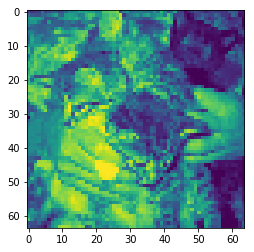

In [85]:
train_data = np.concatenate((train_data_loaded[500:], train_data_loaded[:-500]), axis=0)
plt.imshow(train_data[0])
train_labels = np.concatenate((train_labels_loaded[500:], train_labels_loaded[:-500]), axis=0)
print(train_labels[0])
#print(train_labels)

In [86]:
# Create the Estimator
dogs_vs_cats_classifier = tf.estimator.Estimator(
    model_fn=model_fn, model_dir="./tmp/" + MODEL_NAME)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmp/dogs-vs-cats-tensorflow-3.model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000026314FA6E80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [87]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)


In [88]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
dogs_vs_cats_classifier.train(
    input_fn=train_input_fn,
    steps=300,
    hooks=[logging_hook])
    


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./tmp/dogs-vs-cats-tensorflow-3.model\model.ckpt.
INFO:tensorflow:probabilities = [[1.         0.        ]
 [0.94568145 0.05431848]
 [0.00005764 0.9999423 ]
 [0.         1.        ]
 [0.0000764  0.9999236 ]
 [0.00000001 1.        ]
 [0.         1.        ]
 [0.02098324 0.9790167 ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.00000056 0.9999994 ]
 [0.         1.        ]
 [0.46024445 0.5397555 ]
 [0.99982965 0.00017028]
 [0.00003515 0.99996483]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.9999956  0.00000444]
 [0.00010221 0.99989784]
 [1.         0.        ]
 [0.         1.        ]
 [0.00008864 0.9999113 ]
 [1.      

INFO:tensorflow:global_step/sec: 0.796766
INFO:tensorflow:probabilities = [[0.47735682 0.52264327]
 [0.47546434 0.52453566]
 [0.47631842 0.5236816 ]
 [0.4750099  0.5249902 ]
 [0.47576013 0.5242399 ]
 [0.47633624 0.5236637 ]
 [0.47429758 0.5257025 ]
 [0.4773904  0.5226096 ]
 [0.47336057 0.52663946]
 [0.47605005 0.52395   ]
 [0.47367385 0.5263262 ]
 [0.47659153 0.5234085 ]
 [0.48627156 0.51372844]
 [0.4754368  0.5245632 ]
 [0.47771895 0.522281  ]
 [0.47598487 0.5240151 ]
 [0.47616553 0.52383447]
 [0.47464997 0.52535003]
 [0.47678405 0.52321595]
 [0.47544965 0.5245503 ]
 [0.4743015  0.5256984 ]
 [0.4764016  0.5235984 ]
 [0.47503585 0.5249642 ]
 [0.47910103 0.52089894]
 [0.47609383 0.5239062 ]
 [0.8544192  0.14558078]
 [0.48656029 0.5134397 ]
 [0.4749502  0.52504987]
 [0.5570832  0.44291684]
 [0.4775254  0.5224746 ]
 [0.4759668  0.5240332 ]
 [0.4762593  0.5237407 ]
 [0.47432515 0.5256748 ]
 [0.47719344 0.5228066 ]
 [0.47383928 0.5261607 ]
 [0.512272   0.48772794]
 [0.47551423 0.52448577]
 

In [34]:
#eval_data, eval_labels =  loadImages(False)

[[170. 176. 183. ... 216. 211. 206.]
 [170. 176. 183. ... 218. 214. 209.]
 [170. 176. 183. ... 218. 217. 212.]
 ...
 [130. 134. 137. ...   3.   3.   2.]
 [128. 130. 133. ...   3.   3.   2.]
 [125. 129. 132. ...   2.   2.   2.]]
1


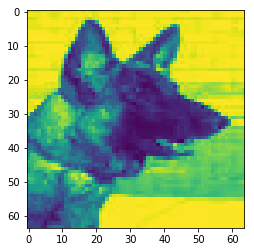

In [89]:
print(eval_data[0])
print(eval_labels[-1])
plt.imshow(eval_data[-1])

0


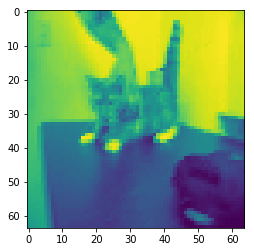

In [90]:
plt.imshow(eval_data[0])
print(eval_labels[0])

In [91]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = dogs_vs_cats_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)



INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-01-15:57:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/dogs-vs-cats-tensorflow-3.model\model.ckpt-300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-01-15:57:12
INFO:tensorflow:Saving dict for global step 300: accuracy = 0.52, global_step = 300, loss = 0.6971896
{'accuracy': 0.52, 'loss': 0.6971896, 'global_step': 300}


In [72]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=None,
    batch_size=128,
    num_epochs=1,
    shuffle=False,
)


predict_results = dogs_vs_cats_classifier.predict(input_fn=predict_input_fn)

<generator object Estimator.predict at 0x000002634A1A5990>


## Premate Estimators

https://www.tensorflow.org/get_started/premade_estimators#create_input_functions

In [73]:

expected = eval_labels
template = ('\nPrediction is "{}" ({:.1f}%), expected "{}"')

for pred_dict, expec in zip(predict_results, expected):
    print(pred_dict)
    break
    class_id = pred_dict['classes']
    probability = pred_dict['probabilities'][class_id]

    print(template.format(expected[class_id],
                          100 * probability, expec))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/dogs-vs-cats-tensorflow-2.model\model.ckpt-610
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'classes': 0, 'probabilities': array([0.64354444, 0.35645553], dtype=float32)}
